In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Read the data from the parquet file
df = pd.read_csv('../../data/heart_failure/train_val_split.csv')
test_df = pd.read_csv('../../data/heart_failure/test_split.csv')

print(len(df) / (len(df) + len(test_df)))

display(df) 


numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']



0.7995642701525054


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,M,ATA,120,157,0,Normal,182,N,0.0,Up,0
730,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
731,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
732,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1


## Exploratory Data Analysis

In [3]:
display(df.isna().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

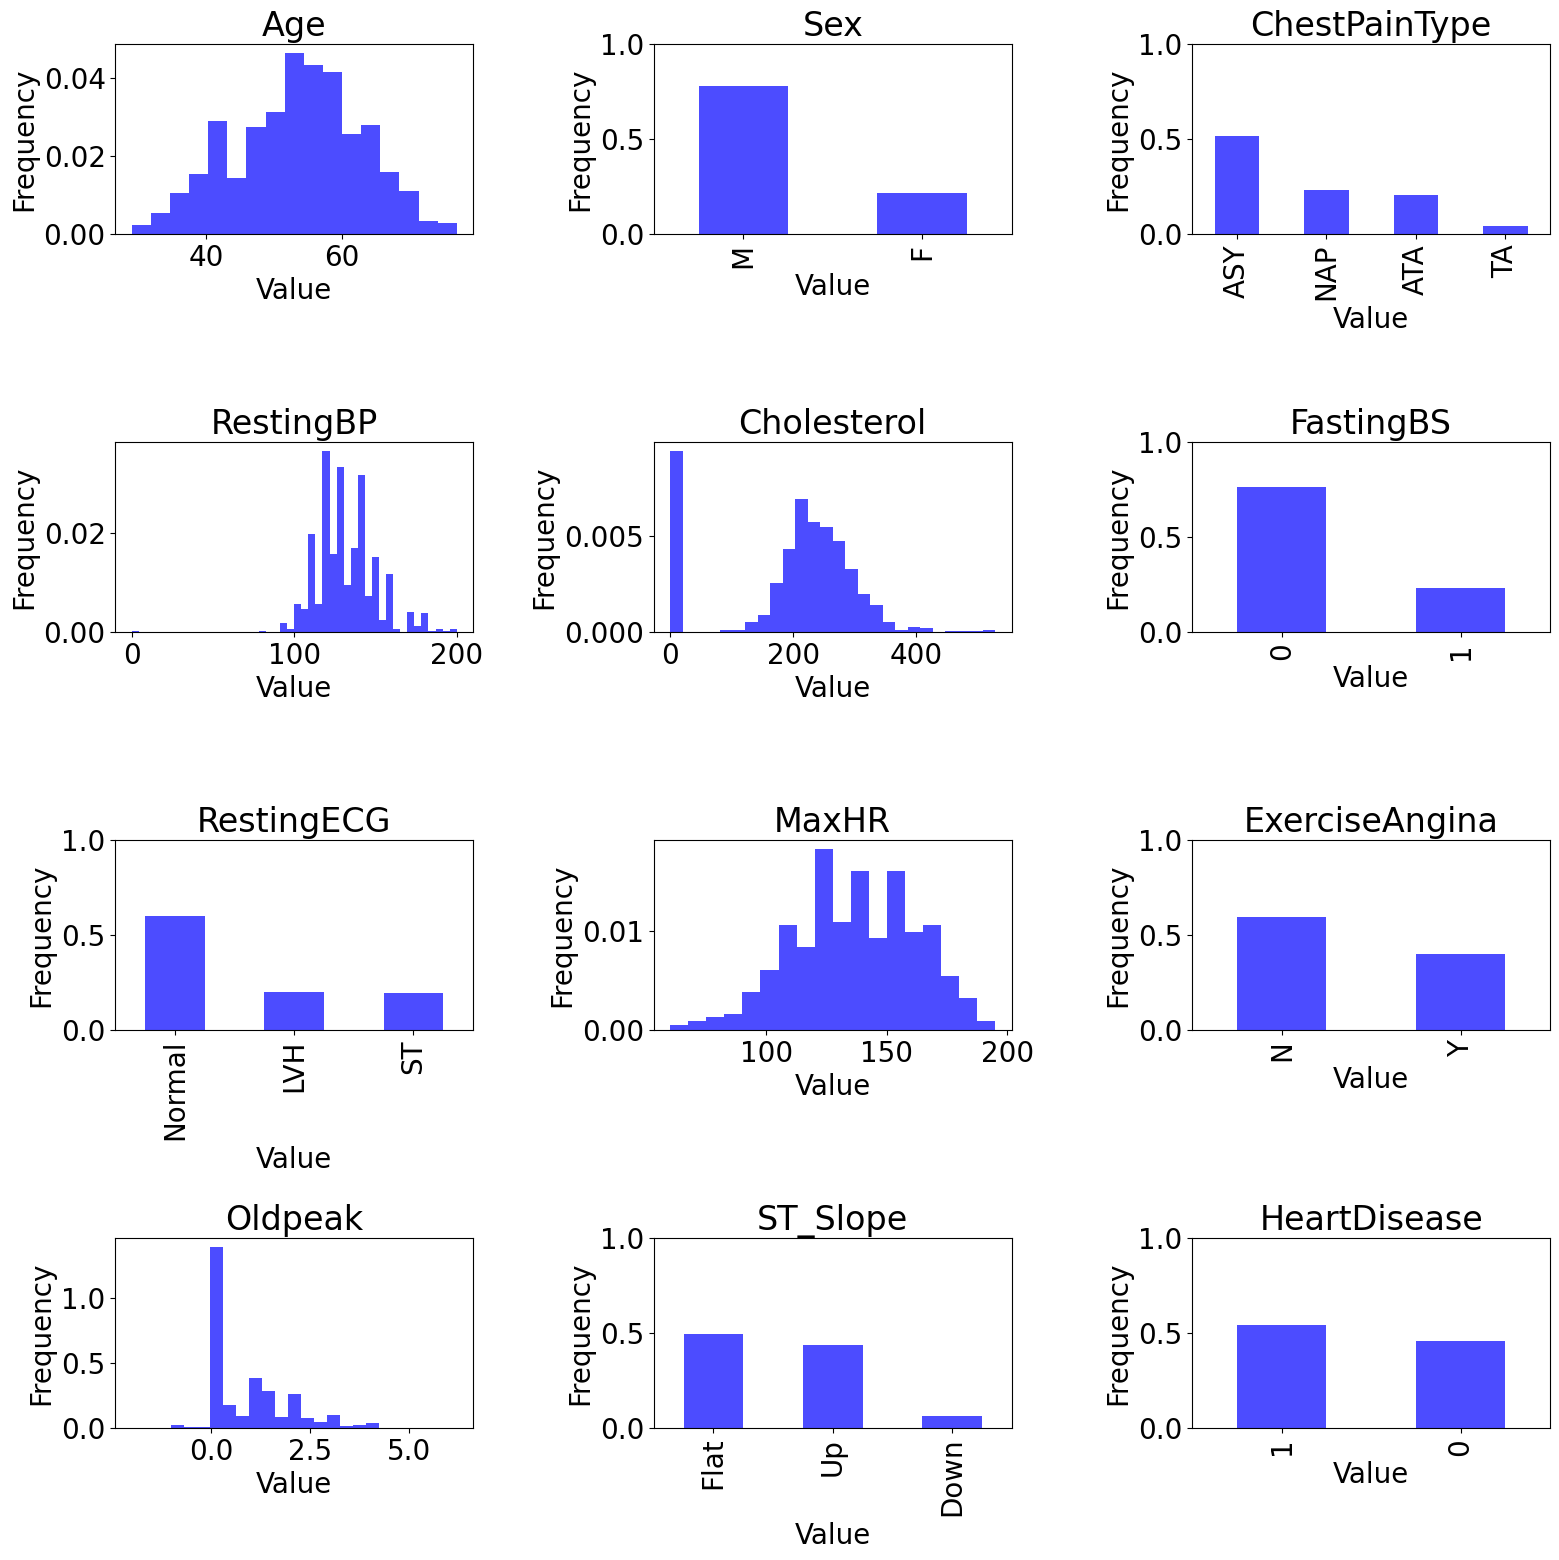

In [4]:
n_cols = 3  # Number of columns in the mosaic
n_rows = int(np.ceil(len(df.columns) / n_cols))  # Number of rows needed

plt.rcParams.update({'font.size': 20}) 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    ax = axes[i]
    if column in numeric_cols:
        ax.hist(df[column].dropna(), bins='auto', color='blue', alpha=0.7, density=True)
    else:
        ax.set_ylim(0, 1)
        (df[column].value_counts() / len(df)).plot(kind='bar', ax=ax, color='blue', alpha=0.7)

    ax.set_title(column)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")


# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

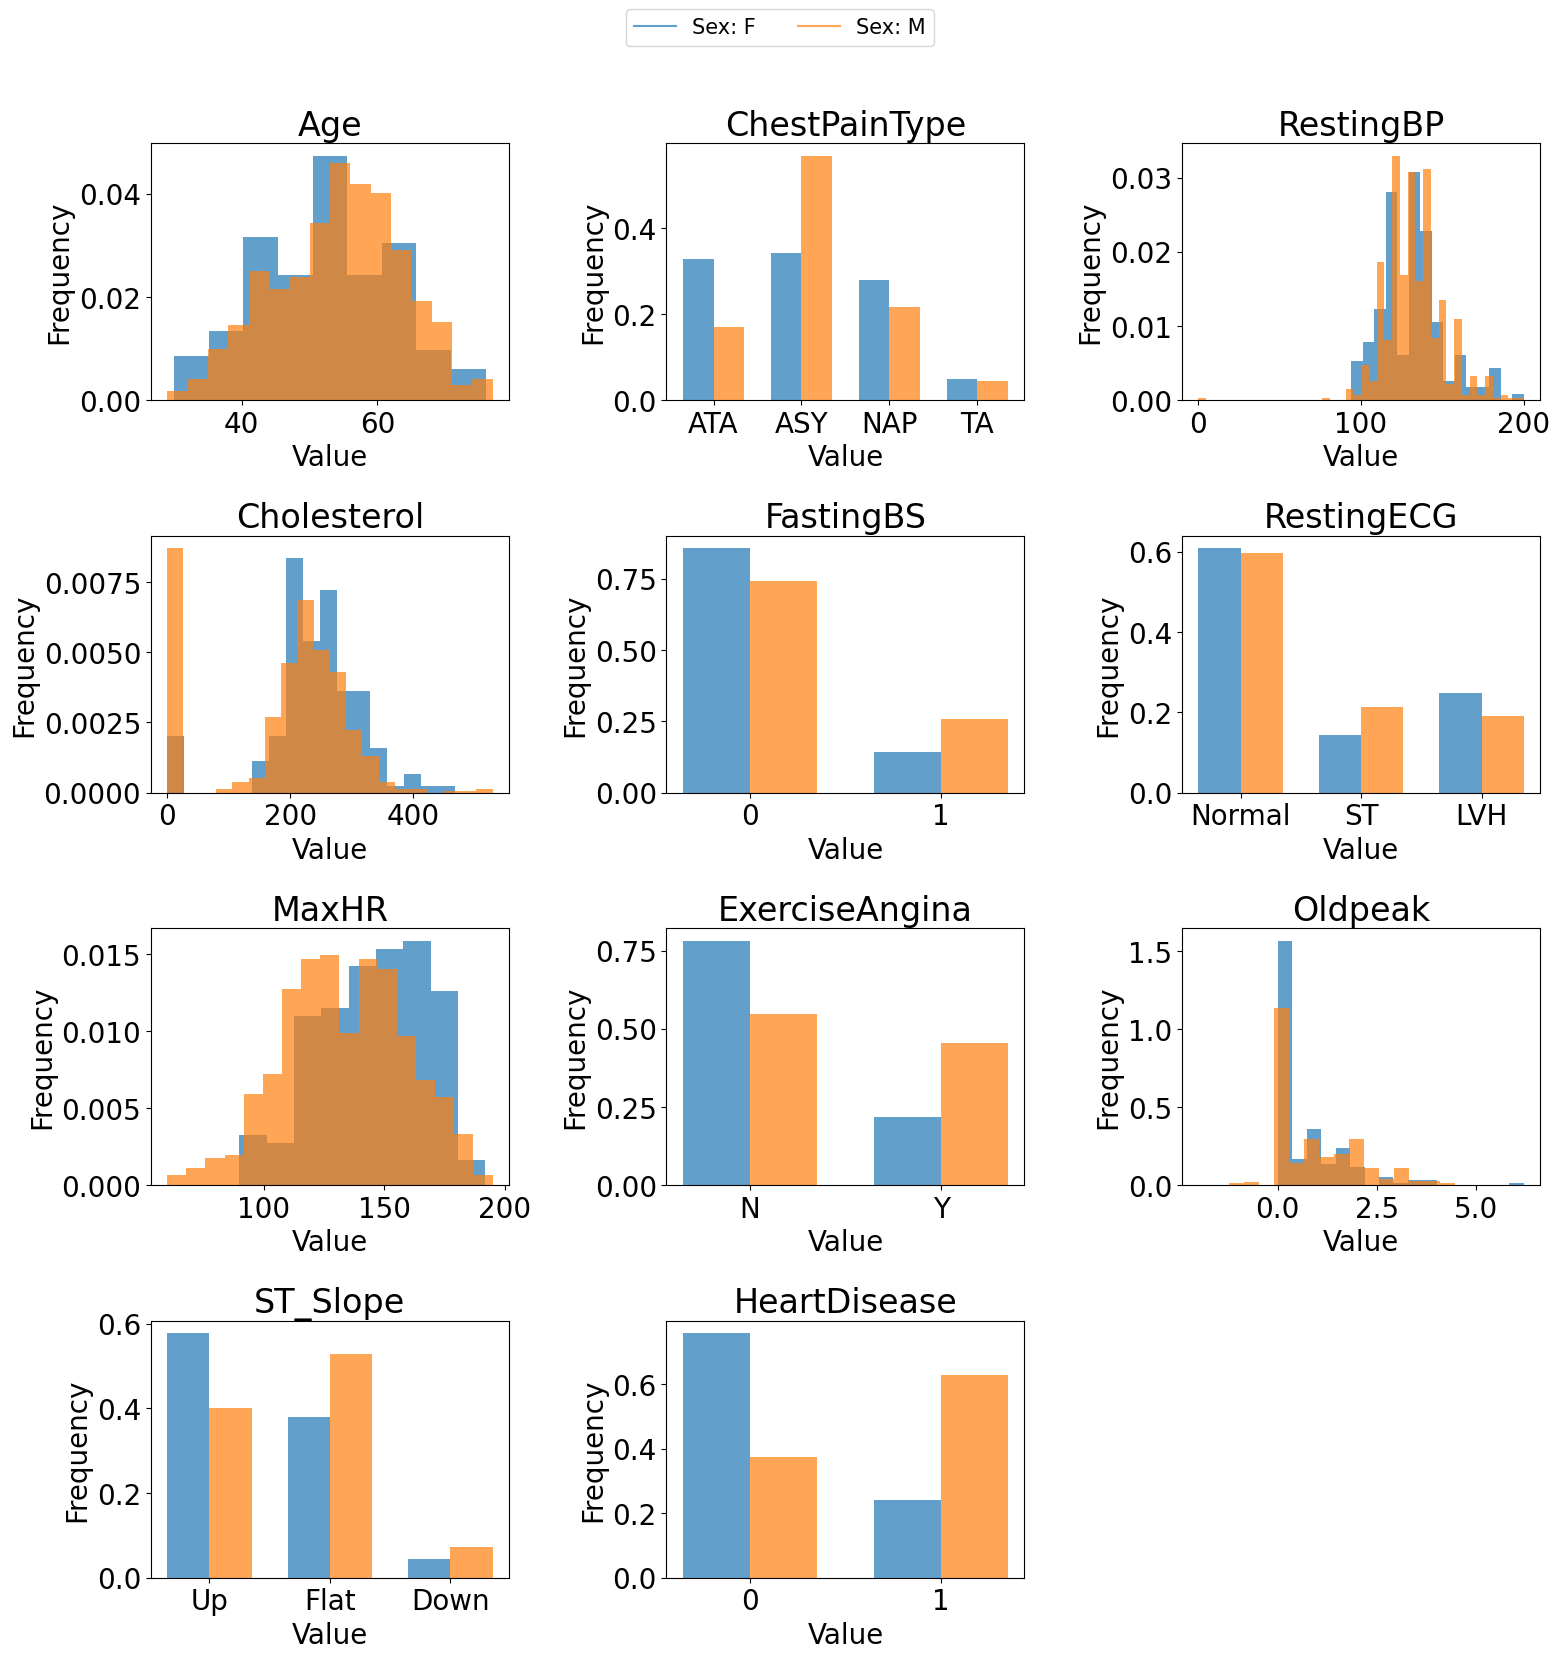

In [5]:
# Grouped plots by 'Sex'
grouped = df.groupby('Sex')

# Exclude the 'Sex' column from the iteration
columns_to_plot = [col for col in df.columns if col != 'Sex']

n_cols = 3  # Number of columns in the mosaic
n_rows = int(np.ceil(len(df.columns) / n_cols))  # Number of rows needed

plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

handles = []  # To store legend handles
labels = []   # To store legend labels

for i, column in enumerate(columns_to_plot):


    ax = axes[i]
    if column in numeric_cols:
        for sex, group in grouped:
            hist = ax.hist(group[column].dropna(), bins='auto', alpha=0.7, label=f"Sex: {sex}", density=True)
            if i == 0:  # Collect legend info only once
                handles.append(plt.Line2D([], [], color=hist[2][0].get_facecolor(), alpha=0.7))
                labels.append(f"Sex: {sex}")
    else:
        # Side-by-side bar plots for categorical variables
        categories = df[column].dropna().unique()
        x = np.arange(len(categories))  # x-axis positions
        width = 0.35  # Width of each bar

        for j, (sex, group) in enumerate(grouped):
            counts = group[column].value_counts(normalize=True).reindex(categories, fill_value=0)
            bar = ax.bar(x + j * width, counts, width=width, alpha=0.7, label=f"Sex: {sex}")
            if i == 0 and j == 0:  # Collect legend info only once
                handles.append(bar[0])
                labels.append(f"Sex: {sex}")

        ax.set_xticks(x + width / 2)
        ax.set_xticklabels(categories)

    ax.set_title(column)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a single legend for the entire figure
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize=15)

plt.tight_layout()
plt.show()

In [6]:
max_value = df['Age'].max()
min_value = df['Age'].min()

print(f"Maximum value: {max_value}")
print(f"Minimum value: {min_value}")

Maximum value: 77
Minimum value: 29


/tmp/ipykernel_105397/2230877030.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('AgeGroup')


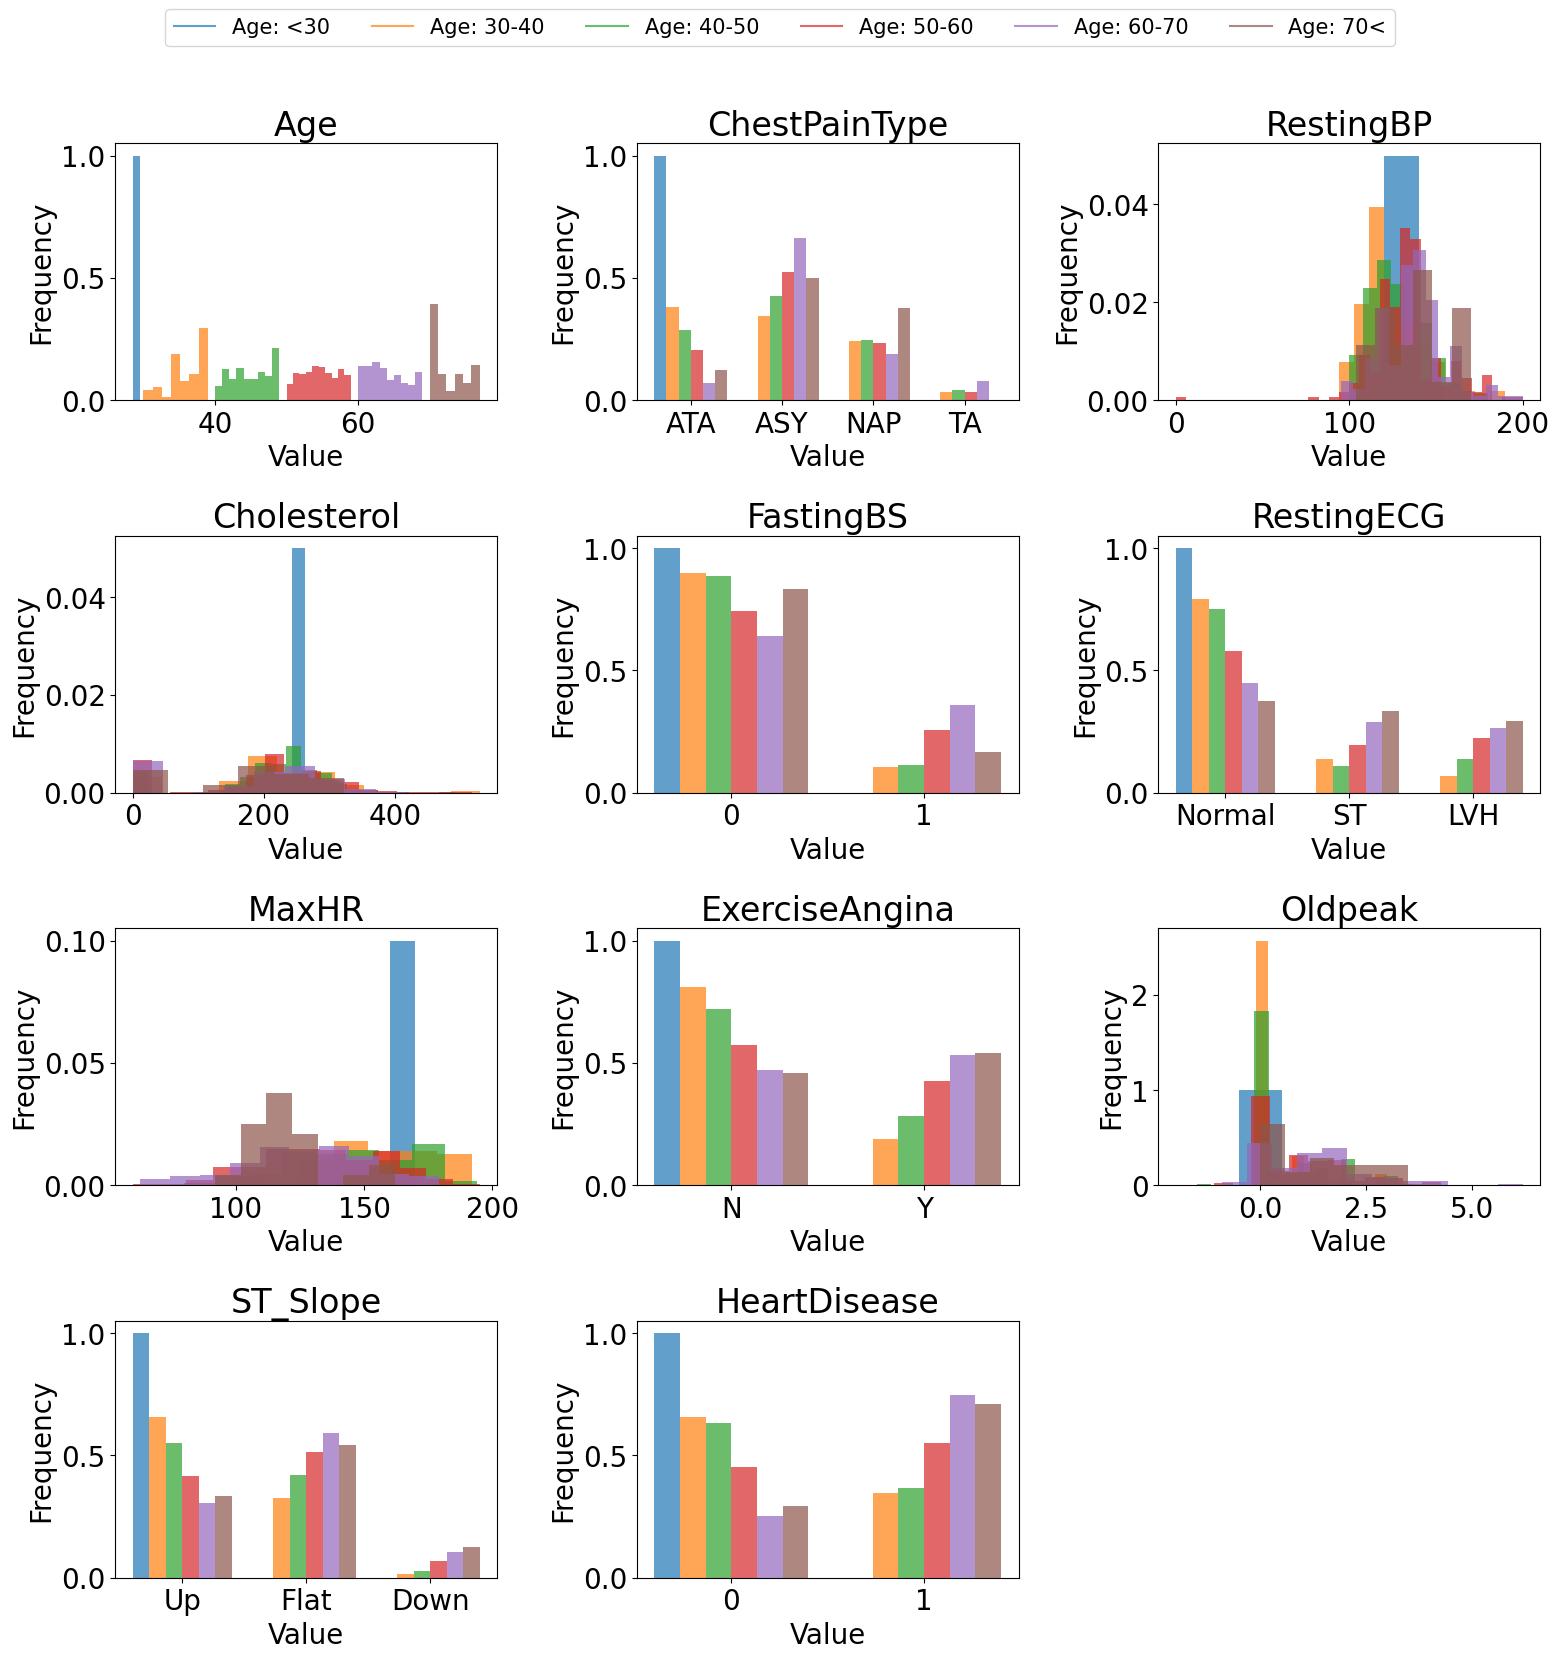

In [7]:
# Define age bins and labels
bins = [0, 30, 40, 50, 60, 70, np.inf]
labels_age = ['<30', '30-40', '40-50', '50-60', '60-70', '70<']

# Create AgeGroup column
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels_age, right=False)

# Group by AgeGroup
grouped = df.groupby('AgeGroup')

# Exclude the grouping column from plots
columns_to_plot = [col for col in df.columns if col not in ['Sex', 'AgeGroup']]

n_cols = 3
n_rows = int(np.ceil(len(columns_to_plot) / n_cols))

plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

handles = []
labels = []

for i, column in enumerate(columns_to_plot):
    ax = axes[i]

    if column in numeric_cols:
        for group_name, group in grouped:
            hist = ax.hist(group[column].dropna(), bins='auto', alpha=0.7, label=f"Age: {group_name}", density=True)
            if i == 0:
                handles.append(plt.Line2D([], [], color=hist[2][0].get_facecolor(), alpha=0.7))
                labels.append(f"Age: {group_name}")
    else:
        categories = df[column].dropna().unique()
        x = np.arange(len(categories))
        width = 0.8 / len(labels_age)  # Adjust bar width based on number of age groups

        for j, (group_name, group) in enumerate(grouped):
            counts = group[column].value_counts(normalize=True).reindex(categories, fill_value=0)
            bar = ax.bar(x + j * width, counts, width=width, alpha=0.7, label=f"Age: {group_name}")
            if i == 0 and j == 0:
                handles.append(bar[0])
                labels.append(f"Age: {group_name}")

        ax.set_xticks(x + width * (len(labels_age) - 1) / 2)
        ax.set_xticklabels(categories)

    ax.set_title(column)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(labels), fontsize=15)

plt.tight_layout()
plt.show()


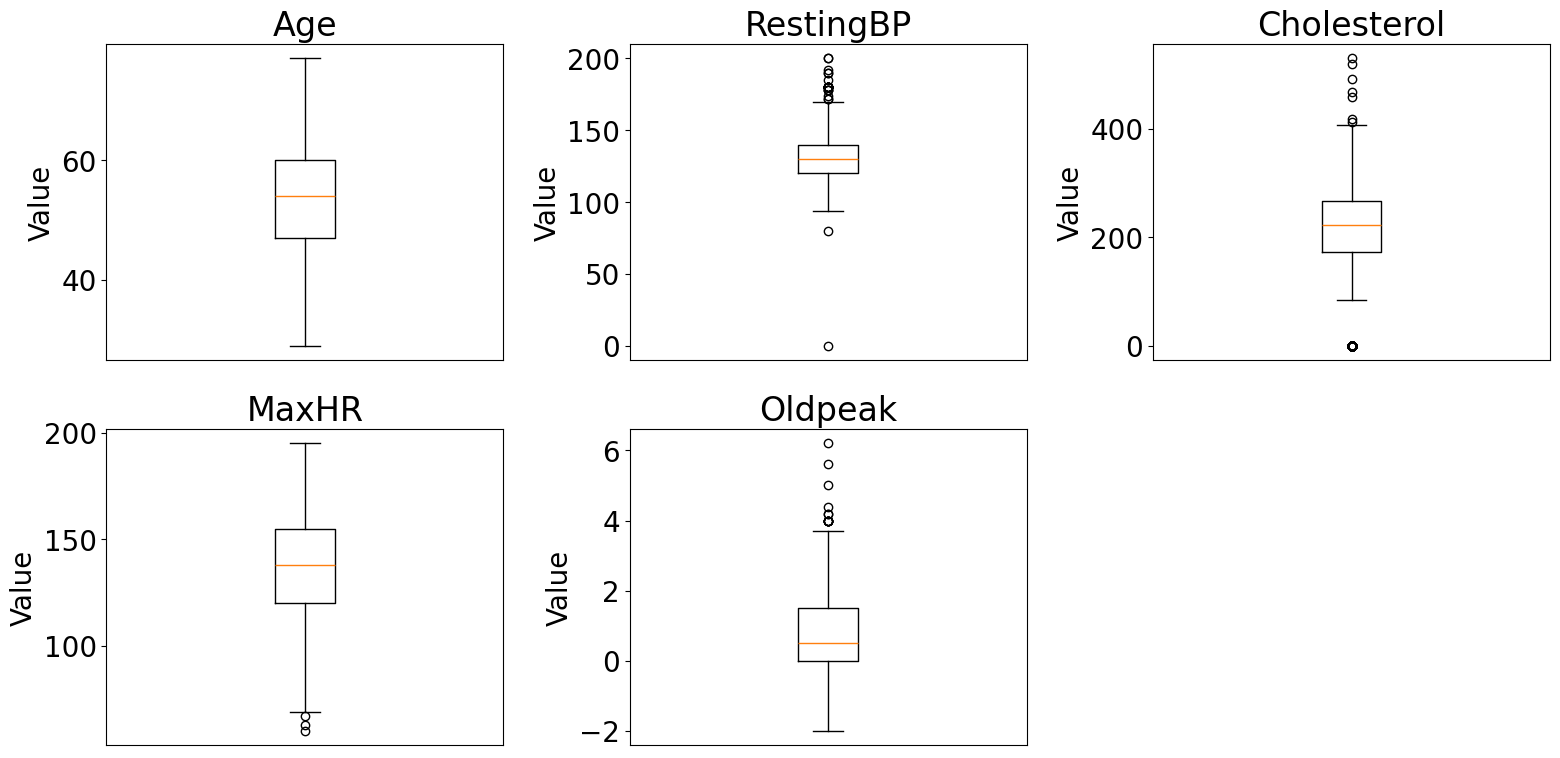

In [8]:
plt.rcParams.update({'font.size': 20})
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for i, column in enumerate(numeric_cols):
    ax = axes[i]
    ax.boxplot(df[column].dropna())
    ax.set_title(column)
    ax.set_ylabel("Value")
    ax.set_xticks([])  # 

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()